# Tutorial: Recovering an AES key by Differential Fault Analysis attack
This tutorial will introduce you to the Differential Fault Analysis (DFA) attack. It will show you how to configure the XMEGA target to perform AES encryptions, how to glitch the encryption operations and introduce errors in the computed ciphertext and finally how to process these glitched ciphertexts to extract the AES key. This can be used as how-to for attacking other targets as well.

Original author: [@doegox](https://twitter.com/doegox)  
License: CC-BY-SA  
Improvements are welcome!

## Prerequisites

### On giants' shoulders
This tutorial is the first to deal with DFA, nevertheless it was not designed from scratch.
It relies on multiple sources we strongly encourage your to read as well for a better understanding of the details.

* The `simpleserial-aes-CW303` target firmware, which contains the software AES implementation used in other side-channel analysis tutorials such as [Using CW Analyzer for CPA Attack](PA_CPA_1-Using_CW-Analyzer_for_CPA_Attack.ipynb). This is the implementation we will attack.
* The glitching tutorials:
  * [Introduction to Glitch Attacks](Fault_1-Introduction_to_Clock_Glitch_Attacks.ipynb), useful to understand the hardware implementation of the glitching module
  * [Tutorial CW305-3 Clock Glitching (wiki)](https://wiki.newae.com/Tutorial_CW305-3_Clock_Glitching) which also presented briefly the principles of glitching AES, but without exploiting the faults
* The DFA attack itself: there is no DFA cryptanalysis code in the Chipwhisperer but we'll re-use a Python library the author of this tutorial wrote for attacking white-box implementations. It's called `phoenixAES` and it is available on [Github](https://github.com/SideChannelMarvels/JeanGrey) and on PyPI.

### Brief introduction to Differential Fault Analysis
We'll only describe the general principle and the operational constraints.

The principle is to repeat the same AES operation over and over and to glitch its intermediate operations to get an output cryptographically incorrect. There are many DFA algorithms which, depending on the nature of the fault (single bit?, single byte?, how many faulted outputs can we collect?...), are able to recover the last round key of the AES with various computations that may be quite intensive.

This tutorial covers the recovering of the key of a simple AES-128 encryption.

We'll use a quite simple DFA published initially by Dusart, Letourneux and Vivolo in 2002 which has nice properties. For a mathematical deep-dive of the DFA we're using in this tutorial, you can read [Differential Fault Analysis on White-box AES Implementations](https://blog.quarkslab.com/differential-fault-analysis-on-white-box-aes-implementations.html) as we will use the exact same DFA library. Moreover, the blog post explains how to tackle DFA against AES decryption and how to attack more than one round, which is required to attack AES-192 or AES-256.

AES-128 is made of 10 rounds, the last one is missing the *MixColumn* operation, the only operation which brings diffusion, i.e. it's an operation which makes a single byte of one round state affecting multiple bytes in the next round, 4 bytes to be exact.

![aes_operations.png](img/aes_operations.png)
(source: http://www.iis.ee.ethz.ch/~kgf/acacia/fig/aes.png)

So, if we inject a fault which affects a single byte between the last two *MixColumn* operations, it will propagate and 4 of the 16 output bytes will be wrong. We don't need to know precisely where we inject our faults, we can simply observe the output and look for a 4-byte fault with one of the 4 possible patterns. The attack is *differential* because we observe the difference between the correct output and the faulty outputs.
We'll save you the maths but with 2 such faults on the same column, there is a high probability to recover a quarter of the round key, so with 4\*2 faults we can recover the entire round key. And because the AES keyschedule is invertible, we can compute it backwards and recover the first round key, which is by definition equal to the AES-128 key.

So, our operational constraints are quite simple: be able to run several times the same AES encryption, with the same key (doh!) and the same plaintext input and be able to collect the ciphertexts. Note that technically we don't need to know the value of the plaintext, we only need it to be constant.

### Installing dependencies

Firstly, let's install `phoenixAES` in the current kernel environment:

In [1]:
import sys
!{sys.executable} -m pip install phoenixAES

  Using cached https://files.pythonhosted.org/packages/b1/83/828b76e81678d039b42c2e22223a46c67b5845e0add95bec192640b3567d/phoenixAES-0.0.2-py3-none-any.whl


## Target

### Which target?

Let's recap. This tutorial is specifically focusing on:
* AES-128 encryption
* the Chipwhisperer Lite ARM XMEGA target
* the AVR crypto lib software implementation of AES
* clock glitching

Other targets and AES implementations should be equally working as well as power glitching. Obviously the glitching parameters will have to be adapted to the corresponding target, which is often not that straightforward.  

Even if you run this tutorial on the same Chipwhisperer Lite target hardware, you might have to alter slightly the glitching parameters to be able to get working glitches. Glitching is so sensitive that running twice the exact same attack hardly produce the exact same results.

### Building the target firmware

If you have the `avr-gcc` toolchain installed, you should be able to build the `simpleserial-aes-CW303` firmware:

In [2]:
PLATFORM = "CW303"
CRYPTO_TARGET = "AVRCRYPTOLIB"

In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

rm -f -- simpleserial-aes-CW303.hex
rm -f -- simpleserial-aes-CW303.eep
rm -f -- simpleserial-aes-CW303.cof
rm -f -- simpleserial-aes-CW303.elf
rm -f -- simpleserial-aes-CW303.map
rm -f -- simpleserial-aes-CW303.sym
rm -f -- simpleserial-aes-CW303.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s aes-independant.s aes_enc.s aes_keyschedule.s aes_sbox.s aes128_enc.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d aes-independant.d aes_enc.d aes_keyschedule.d aes_sbox.d aes128_enc.d
rm -f -- simpleserial-aes.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i aes-independant.i aes_enc.i aes_keyschedule.i aes_sbox.i aes128_enc.i
.
-------- begin --------
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILIT

## Attack setup

### CW-lite connection and target flashing

Connect to the Chipwhisperer:

In [4]:
import chipwhisperer as cw
scope = cw.scope()
target = cw.target(scope)

Setup default scope parameters:

In [5]:
%run "Helper_Scripts/Setup_Target_Generic.ipynb"

Flash the target:

In [6]:
prog = cw.programmers.XMEGAProgrammer
fw_path = "../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-CW303.hex"
cw.programTarget(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3275 bytes


### First execution

For the DFA attack, we need a constant plaintext (and constant key of course).
We could just use two bytearrays but let's use the CW API to demonstrate its usage.


In [7]:
ktp = cw.ktp.Basic(target=target)
ktp.setKeyType(ktp.types['Fixed'])
ktp.setPlainType(ktp.types['Fixed'])
# You can assign another key than the defaut key:
ktp.setInitialKey("2b7e151628aed2a6abf7158809cf4f3c")
key, text = ktp.newPair()

Assuming we want to record traces, let's capture the entire AES.  
It's useful to see which round(s) we'll glitch by tuning `scope.glitch.ext_offset` later.

In [8]:
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 20000

Let's test our setup with a first execution, without fault.
It will give us the golden reference output.

In [9]:
# make sure glitches are disabled (in case cells are re-run)
scope.io.hs2 = "clkgen"

target.init()
target.setModeEncrypt()
target.loadEncryptionKey(key)
target.loadInput(text)
scope.arm()
target.go()
timeout = 50
# wait for target to finish
while target.isDone() is False and timeout:
    timeout -= 1
    time.sleep(0.01)
ret = scope.capture()
trace = scope.getLastTrace()
goldciph = target.readOutput()
print("Plaintext: {}".format(text.hex()))
print("Key:       {}".format(key.hex()))
print("Ciphertext:{}".format(goldciph.hex()))

Plaintext: 000102030405060708090a0b0c0d0e0f
Key:       2b7e151628aed2a6abf7158809cf4f3c
Ciphertext:50fe67cc996d32b6da0937e99bafec60


Just to be sure, let's check...

In [10]:
from Crypto.Cipher import AES
aes = AES.new(bytes(key), AES.MODE_ECB)
goldciph2 = aes.encrypt(bytes(text))
print("Expected ciphertext:  {}".format(goldciph2.hex()))

Expected ciphertext:  50fe67cc996d32b6da0937e99bafec60


Let's draw the full AES execution

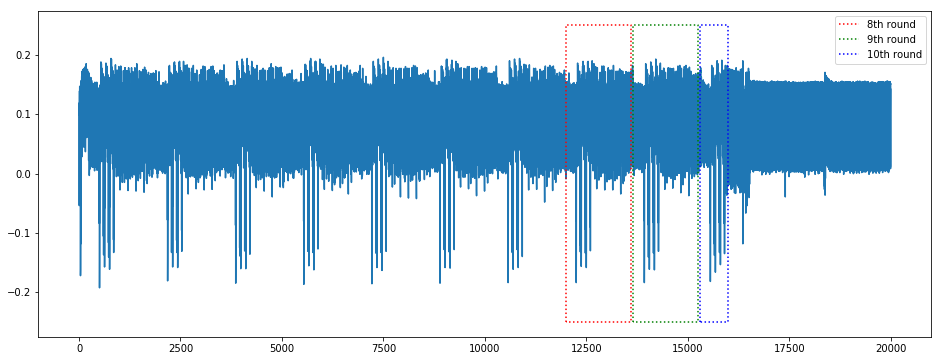

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.plot(trace)

# add boxes around last rounds
plt.plot([12000, 12000, 13600, 13600, 12000], [-0.25, 0.25, 0.25, -0.25, -0.25], 'r:')
plt.plot([13650, 13650, 15250, 15250, 13650], [-0.25, 0.25, 0.25, -0.25, -0.25], 'g:')
plt.plot([15300, 15300, 16000, 16000, 15300], [-0.25, 0.25, 0.25, -0.25, -0.25], 'b:')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='r', ls=':'),
                Line2D([0], [0], color='g', ls=':'),
                Line2D([0], [0], color='b', ls=':'),]
plt.legend(custom_lines, ['8th round', '9th round', '10th round'])

plt.show()

We see clearly the 10 AES-128 rounds, the 10th round being smaller than the others as there is no *MixColumn*.

### First glitches

To check the actual clock glitches with an oscilloscope, you can probe the XTal pad which is connected to R72 and run the following function to glitch all clock cycles during 2 seconds. Beware that the probe influences slightly the signal and it's enough to require a different tuning of the glitching parameters, so when you're attacking a target, do it all with or all without the oscilloscope but avoid messing up your setup!
In this tutorial, parameters were tuned without attached probe. Still, your board might require slightly different values.

In [12]:
import time

def test_glitches():
    scope.io.hs2 = "glitch"
    scope.glitch.clk_src = 'clkgen'
    scope.glitch.width=3.5
    scope.glitch.offset=34
    scope.glitch.trigger_src='continuous'

def stop_test_glitches():
    scope.glitch.trigger_src='ext_single'

test_glitches()
time.sleep(2)
stop_test_glitches()

Here is an example of five glitched clock cycles as seen with an oscilloscope:
![clock_glitches.png](img/clock_glitches.png)

See how the actual width and offset values are rounded to the internal step values.

In [13]:
print(scope.glitch)

clk_src     = clkgen
width       = 3.515625
width_fine  = 0
offset      = 33.984375
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 0
repeat      = 1
output      = clock_xor



Let's define a `MIN_STEP` equal to the internal step value, it'll be our "unit" width and offset step and other values will be rounded to the closest multiple.

In [14]:
MIN_STEP=25/64

Let's see the effect of clock glitches on the AES execution.

In [15]:
# Initial glitch parameters
scope.io.hs2 = "glitch"
scope.glitch.clk_src = 'clkgen'
scope.glitch.trigger_src = 'ext_single'
scope.glitch.width = 6*MIN_STEP
scope.glitch.offset = 34.5
scope.glitch.ext_offset = 13400
scope.glitch.repeat = 10

# reset target
scope.io.pdic = 'low'
time.sleep(0.1)
scope.io.pdic = 'high'

# go!
target.init()
scope.arm()
target.go()

# wait for target to finish
timeout = 50
while target.isDone() is False and timeout:
    timeout -= 1
    time.sleep(0.01)

# acquire the trace
scope.capture()
trace = scope.getLastTrace()

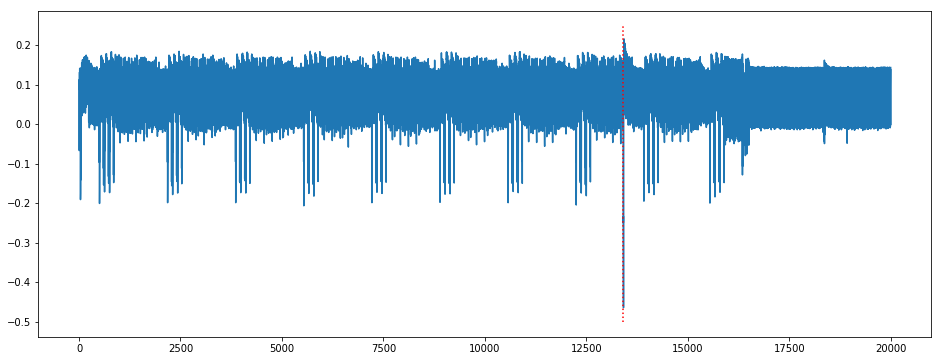

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.plot(trace)
plt.plot([scope.glitch.ext_offset, scope.glitch.ext_offset], [-0.5, 0.25], 'r:')
plt.show()


You should see a glitch in the power trace (blue) when the clock was glitched (red dotted line).  
As said earlier, glitch parameters may have to be adapted to your specific hardware.  Our experience is that a good `scope.glitch.width` is one just a bit smaller than one producing a clearly visible glitch in the power trace. E.g. the trace above was created with `scope.glitch.width=6*MIN_STEP` and we'll use `scope.glitch.width=5*MIN_STEP` in our attack. If this is not precise enough, consider tuning `scope.glitch.width_fine` too.

### Campain setup
Now, we'll prepare a campain of clock glitches to induce faults.

The following code is a bit more complex than strictly needed but we want to be able to compute exactly how many executions will be performed depending on the ranges and steps of the variables we want to tune. This allows us to get a nice progress bar.  
We'll sample three different axes:
* `scope.glitch.width`: clock glitch width
* `scope.glitch.offset`: clock glitch offset
* `scope.glitch.ext_offset`: offset since the initial trigger (to target the last rounds)


In [17]:
from collections import namedtuple
# named tuples to make it easier to change the scope of the test
Range = namedtuple('Range', ['min', 'max', 'step'])

import math

# get control over logging in order to be able to mask target execution errors,
# which can easily happen when glitching the target!
import logging
logging.basicConfig(level=logging.WARN)

# Let's be prepared for user-provided ranges: rounding and checking consistency by ourselves.
def apply_ranges():
    global width_range, width_range_steps
    global offset_range, offset_range_steps
    global extoffset_range, extoffset_range_steps
    width_step_sign = width_range.step/abs(width_range.step)
    offset_step_sign = offset_range.step/abs(offset_range.step)
    width_range = Range(width_range.min, width_range.max, round(width_range.step / MIN_STEP) * MIN_STEP)
    offset_range = Range(offset_range.min, offset_range.max, round(offset_range.step / MIN_STEP) * MIN_STEP)
    if abs(width_range.step) < MIN_STEP:
        step = width_step_sign*MIN_STEP
        logging.error('width_range.step too small, adjusting to {}'.format(step))
        width_range = Range(width_range.min, width_range.max, step)
    if abs(offset_range.step) < MIN_STEP:
        step = offset_step_sign*MIN_STEP
        logging.error('offset_range.step too small, adjusting to {}'.format(step))
        offset_range = Range(offset_range.min, offset_range.max, step)
    width_range_steps = math.ceil((width_range.max-width_range.min)/width_range.step)
    offset_range_steps = math.ceil((offset_range.max-offset_range.min)/offset_range.step)
    extoffset_range_steps = math.ceil((extoffset_range.max-extoffset_range.min)/extoffset_range.step)
    if width_range_steps < 0:
        step = -width_range.step
        logging.error('width_range.step has wrong sign, adjusting to {}'.format(step))
        width_range = Range(width_range.min, width_range.max, step)
        width_range_steps = -width_range_steps
    if offset_range_steps < 0:
        step = -offset_range.step
        logging.error('offset_range.step has wrong sign, adjusting to {}'.format(step))
        offset_range = Range(offset_range.min, offset_range.max, step)
        offset_range_steps = -offset_range_steps
    if extoffset_range_steps < 0:
        step = -extoffset_range.step
        logging.error('extoffset_range.step has wrong sign, adjusting to {}'.format(step))
        extoffset_range = Range(extoffset_range.min, extoffset_range.max, step)
        extoffset_range_steps = -extoffset_range_steps

This is not strictly required for the tutorial but here are few global variables that you can tune to decide if, besides the DFA attack, you want also to:
* `GLITCH_RESULTS_FILEPATH`: record the ciphertexts in a CSV file (string or None)
* `TRACES_FILEPATH`: record the consumption traces in a Numpy file (string or None)

The goal is to demonstrate various parts of the CW API that might help you debugging real-life DFA campains.

In [18]:
GLITCH_RESULTS_FILEPATH='/tmp/glitch_outputs.csv'
TRACES_FILEPATH='/tmp/glitch_traces.npy'

The next cell defines the glitches campain.    
`traces` is the list of recorded traces, `output` the list of outputs, either errors (e.g. if the target crashed) or (faulty or correct) ciphertexts. To be able to display a table of the glitch results and the faulty ciphertexts, we'll store the interesting information in the list `results`.

In [19]:
def campain():
    import time
    global traces, outputs, results
    traces = []
    outputs = []
    results = [['#', 'target output', 'width', 'offset', 'extoffset', 'interesting']]

    # Initial glitch parameters
    scope.io.hs2 = "glitch"
    scope.glitch.clk_src = 'clkgen'
    scope.glitch.trigger_src = 'ext_single'
    scope.glitch.repeat = glitch_repeat
    scope.glitch.width = width_range.min
    scope.glitch.offset = offset_range.min
    scope.glitch.ext_offset = extoffset_range.min

    if GLITCH_RESULTS_FILEPATH is not None:
        import csv
        f = open(GLITCH_RESULTS_FILEPATH, 'w')
        writer = csv.writer(f)

    # campain loop with progress bar
    from tqdm import tnrange, tqdm
    for i in tqdm(range(width_range_steps*offset_range_steps*extoffset_range_steps), desc='Capturing traces', file=sys.stdout):

        # reset target
        scope.io.pdic = 'low'
        time.sleep(0.1)
        scope.io.pdic = 'high'

        # not very useful in this case as we're using fixed key & text, but this demonstrates the API.
        key, text = ktp.newPair()

        # go!
        target.init()
        target.setModeEncrypt()
        target.loadEncryptionKey(key)
        target.loadInput(text)
        scope.arm()
        target.go()

        # wait for target to finish
        timeout = 50
        while target.isDone() is False and timeout:
            timeout -= 1
            time.sleep(0.01)

        # shall we acquire the trace?
        if TRACES_FILEPATH is not None:
            try:
                ret = scope.capture()
                if ret:
                    logging.warning('Timeout happened during acquisition')
            except IOError as e:
                logging.error('IOError: %s' % str(e))
            traces.append(scope.getLastTrace())

        # read target output from the target's buffer
        # we know it can fail, so let's silent warnings for now
        logging.getLogger().setLevel(logging.ERROR)
        output = target.readOutput()
        logging.getLogger().setLevel(logging.WARN)

        # at this stage, we consider any 32b output different from the reference as potentially interesting
        interesting = output is not None and len(output) == 16 and output != goldciph

        # let's record it
        if output is not None and len(output) == 16:
            r = bytes(output).hex()
        else:
            r = repr(output)
        data = [i, r, scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset, interesting]
        results.append(data)

        if GLITCH_RESULTS_FILEPATH is not None:
            writer.writerow(data)
        if interesting:
            outputs.append(output)

        # loop update: compute next set of parameters
        scope.glitch.ext_offset += extoffset_range.step
        if scope.glitch.ext_offset >= extoffset_range.max:
            scope.glitch.ext_offset = extoffset_range.min
            scope.glitch.offset += offset_range.step
            if scope.glitch.offset >= offset_range.max:
                scope.glitch.offset = offset_range.min
                scope.glitch.width += width_range.step

    # we're done
    if GLITCH_RESULTS_FILEPATH is not None:
        f.close()

    # optionally save traces to a file for later processing
    if TRACES_FILEPATH is not None:
        import numpy as np
        trace_array = np.asarray(traces)
        print()
        print('Saving traces to {}'.format(TRACES_FILEPATH))
        np.save(TRACES_FILEPATH, trace_array)

## Attacking the 9th round

### R9: Collecting faulty outputs

In this attack, we'll try to glitch the 9th round:

In [20]:
# for scope.glitch.width:
width_range = Range(5*MIN_STEP, 6*MIN_STEP, MIN_STEP)
# Example when applying an oscilloscope probe, its capacitance is cushioning glitches so we need to beef them
#width_range = Range(9*MIN_STEP, 10*MIN_STEP, MIN_STEP)

# for scope.glitch.offset:
offset_range = Range(34.5, 35.5, MIN_STEP)

# for scope.glitch.ext_offset:
extoffset_range = Range(13400, 14300, 10)

# for scope.glitch.repeat:
glitch_repeat = 10

apply_ranges()

Yes, I know, `width_range` contains a single value in our setup, but at least you're ready for scanning more values!

The next cell runs the glitches campain. Till you don't disconnect the Chipwhisperer, you can re-run the campain and analyze its results several times.  
Even when the parameters are perfectly maintained, the glitch effects are never twice exactly the same and the results of our campains may vary quite a lot.  
Adjust these parameters if you don't get proper results. Roughly:
* Increase `scope.glitch.width` width and/or vary `scope.glitch.offset` if the output is never faulted
* Decrease `scope.glitch.width` width and/or vary `scope.glitch.offset` if there is no output (target crashed)
* Play also with `scope.glitch.width_fine` if needed
* Avoid increasing too much `scope.glitch.repeat` as you don't want to inject mutiple faults affecting several bytes at once
* Beware of the effect of an oscilloscope probe if you're monitoring the glitches

The goal is to collect as many *interesting* outputs as possible. An *interesting* output at this stage is simply a 16-byte output different from the reference output.


In [21]:
campain()

Capturing traces: 100%|██████████| 270/270 [01:26<00:00,  2.74it/s]

Saving traces to /tmp/glitch_traces.npy


Let's see the results:

In [22]:
from terminaltables import AsciiTable
table = AsciiTable(results)
print(table.table)

+-----+----------------------------------+----------+-----------+-----------+-------------+
| #   | target output                    | width    | offset    | extoffset | interesting |
+-----+----------------------------------+----------+-----------+-----------+-------------+
| 0   | 50fe675f996dfdb6da4037e976afec60 | 1.953125 | 34.375    | 13400     | True        |
| 1   | feb4ab74ec360dc1fe0a7157618d5bc6 | 1.953125 | 34.375    | 13410     | True        |
| 2   | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 13420     | False       |
| 3   | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 13430     | False       |
| 4   | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 13440     | False       |
| 5   | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 13450     | False       |
| 6   | e0a113a5dd413e86f21f4f5d5c2f9577 | 1.953125 | 34.375    | 13460     | True        |
| 7   | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 13470     | Fa

### R9: Cryptanalysis of the faulty outputs

We'll use `phoenixAES` to perform the DFA against the collected ciphertexts.

All it requires is the list of *interesting* outputs and the reference output.

In [23]:
import phoenixAES
r10=phoenixAES.crack_bytes(outputs, goldciph, encrypt=True, verbose=2)

50fe675f996dfdb6da4037e976afec60: group 3
feb4ab74ec360dc1fe0a7157618d5bc6: group None
e0a113a5dd413e86f21f4f5d5c2f9577: group None
50fe58cc99d732b60c0937e99bafecab: group 2
4f63651109f52098ed6d3fb12ae80e41: group None
4f128e11fa0f2098776d3f6b2ae88104: group None
d671114a2a1bd925be8390e2cbbc8dcc: group None
50fe6776996dd6b6dafe37e9cbafec60: group 3
Round key bytes recovered:
......A8....25....3F....B6......
aa1202ccfa7d328d7109b56b9b838187: group None
40fe67cc996d3217da09cce99bc0ec60: group 0
50f067cc7f6d32b6da0937199bafd760: group 1
381a23d07fccb48cafad12e844413954: group None
d805c0c42cee9ee2fca526d0cf32a2bc: group None
500667ccb06d32b6da0937489baff460: group 1
Round key bytes recovered:
..14..A8C9..25....3F..C8B6..0C..
9d413b5c91970f9d913acef3abdf1041: group None
e09367cc656d320ada09ccb29b3a9660: group None
e0fe67cc996d320ada09cce99b3aec60: group 0
50fe10cc994b32b6b80937e99bafecab: group 2
ebfe67cc996d32ddda098de99b07ec60: group 0
Round key bytes recovered:
D014..A8C9..2589..3F0CC8B

In this first attack, we assume the fault was injected *between* the last two *MixColumn* operations and we look for ciphertexts only partially (25%) corrupted.  
We hope you managed to recover the full 10th round key. If not, you may try again [from here](#R9:-Collecting-faulty-outputs) :) If you got very few or no "interesting" ciphertexts, better to tune `width_range`.   
Once the last round key is recovered, you can revert the AES keyscheduling and reveal the actual AES key.

In [24]:
key=None
if r10 is not None:
    from chipwhisperer.analyzer.attacks.models.aes.key_schedule import keyScheduleRounds
    key = keyScheduleRounds(bytearray.fromhex(r10), 10, 0)
    print("AES Key:")
    print(''.join("%02x" % x for x in key))
else:
    print("Sorry, no key found, try another campain, maybe with different parameters...")

AES Key:
2b7e151628aed2a6abf7158809cf4f3c


### R9: Plotting inner states differences

Once the AES key is known, we can display where the actual faults were injected, here plotting the first 10 outputs.

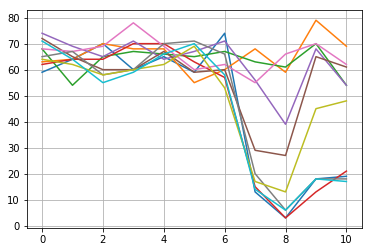

In [25]:
%run "Helper_Scripts/AES_differential_plotter.ipynb"
if key is not None:
    ad=AesDiff(intext=text, key=key, encrypt=True)
    for c in outputs[:10]:
        ad.add_glitch(c)
    plt=ad.plot_diff_bits()
    plt.show()

This graph shows how many bits were flipped at each round. Of course the plot only makes sense from the lowest points of the curve to the right, there is no fault diffusion from the fault to the left.  
We're more interested in the number of bytes which are faulted before the last *MixColumn*:

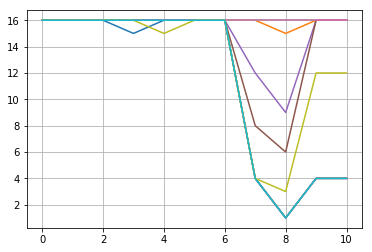

In [26]:
if key is not None:
    plt=ad.plot_diff_bytes()
    plt.show()

We managed to break the key because indeed a number of executions was properly faulted on a single byte before the last *MixColumn*, cf the lowest curves at position 8.

## Attacking the 8th round

To reduce the number of required faults, we can inject glitches one round earlier.
If the faults are injected one *MixColumn* earlier, in the 8th round, the ciphertext will be completely corrupted.
But we can still apply the same cryptanalysis!
The trick is to convert one such fault into four faults on the 9th round.

### R8: Collecting faulty outputs

Let's change our parameters to attack one round earlier and launch our attack.

In [27]:
# for scope.glitch.ext_offset:
extoffset_range = Range(12000, 12200, 20)
apply_ranges()
campain()

Capturing traces: 100%|██████████| 30/30 [00:08<00:00,  2.95it/s]

Saving traces to /tmp/glitch_traces.npy


Let's see the results:

In [28]:
from terminaltables import AsciiTable
table = AsciiTable(results)
print(table.table)

+----+----------------------------------+----------+-----------+-----------+-------------+
| #  | target output                    | width    | offset    | extoffset | interesting |
+----+----------------------------------+----------+-----------+-----------+-------------+
| 0  | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 12000     | False       |
| 1  | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 12020     | False       |
| 2  | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 12040     | False       |
| 3  | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 12060     | False       |
| 4  | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 12080     | False       |
| 5  | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 12100     | False       |
| 6  | 454ba912224b3f241b7368d4aa19f828 | 1.953125 | 34.375    | 12120     | True        |
| 7  | 50fe67cc996d32b6da0937e99bafec60 | 1.953125 | 34.375    | 12140     | False       |

### R8: Cryptanalysis of the faulty outputs

In this second attack, we assume the fault was injected *before* the last two *MixColumn* operations.
First, we convert each 100% faulty output into four 25% faulty outputs and then we apply the same attack as before.

In [29]:
outputs2=phoenixAES.convert_r8faults_bytes(outputs, goldciph, encrypt=True)
r10=phoenixAES.crack_bytes(outputs2, goldciph, encrypt=True, verbose=2)

45fe67cc996d3224da0968e99b19ec60: group 0
504b67cc226d32b6da0937d49baff860: group 1
50fea9cc994b32b61b0937e99bafec28: group 2
50fe6712996d3fb6da7337e9aaafec60: group 3
c3fe67cc996d32f2da0904e99bd0ec60: group 0
506a67ccd36d32b6da0937599baf0060: group 1
50fe89cc99fb32b6370937e99bafec54: group 2
50fe6768996dcfb6da5037e9d2afec60: group 3
f1fe67cc996d32cada0913e99b0aec60: group 0
50cb67cc006d32b6da0937199baf7260: group 1
50fed0cc995b32b6730937e99bafec5f: group 2
50fe6751996d7bb6da8637e9ddafec60: group 3
2afe67cc996d32a2da0955e99b9fec60: group 0
Round key bytes recovered:
D0............89....0C....63....
50f967cc456d32b6da0937be9baf4460: group 1
Round key bytes recovered:
D014....C9....89....0CC8..630C..
50fe57cc995932b6dc0937e99bafece5: group 2
Round key bytes recovered:
D014F9..C9EE..89E1..0CC8..630CA6
50fe67c1996d9cb6daf537e93dafec60: group 3
Round key bytes recovered:
D014F9A8C9EE2589E13F0CC8B6630CA6
Last round key #N found:
D014F9A8C9EE2589E13F0CC8B6630CA6


We hope you managed to recover the full 10th round key. If not, you may try again [from here](#R8:-Collecting-faulty-outputs). 
Once the last round key is recovered, you can revert the AES keyscheduling and reveal the actual AES key.

In [30]:
if r10 is not None:
    from chipwhisperer.analyzer.attacks.models.aes.key_schedule import keyScheduleRounds
    key = keyScheduleRounds(bytearray.fromhex(r10), 10, 0)
    print("AES Key:")
    print(''.join("%02x" % x for x in key))
else:
    print("Sorry, no key found, try another campain, maybe with different parameters...")

AES Key:
2b7e151628aed2a6abf7158809cf4f3c


### R8: Plotting inner states differences

Let's plot the fault diffusion of the first 10 outputs.

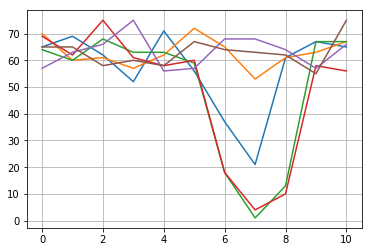

In [31]:
%run "Helper_Scripts/AES_differential_plotter.ipynb"
if key is not None:
    ad=AesDiff(intext=text, key=key, encrypt=True)
    for c in outputs[:10]:
        ad.add_glitch(c)
    plt=ad.plot_diff_bits()
    plt.show()

And grouped by faulty bytes. We now see that we get single byte faults one round earlier:

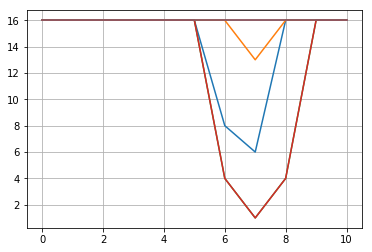

In [32]:
if key is not None:
    plt=ad.plot_diff_bytes()
    plt.show()

## The end

Once you're done, clean up the connection to the scope and target.  
**Warning**, once disconnected, you'll have to run the cells since the [CW-lite connection and target flashing](#CW-lite-connection-and-target-flashing) section to be connected again.

In [33]:
scope.dis()
target.dis()

This tutorial is over.  
You might now try to attack other instances by yourself, e.g. recompile the target with `CRYPTO_TARGET = "TINYAES128C"` and try to break it!